# **Masked Face Recognition**

##Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import cv2
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
from sklearn.model_selection import train_test_split
import os
from glob import glob

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = '/content/drive/MyDrive/COMASK20_Mini_split/train/'
test_path = '/content/drive/MyDrive/COMASK20_Mini_split/test/'
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 402 files belonging to 49 classes.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 178 files belonging to 49 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['1', '10', '11', '12', '13', '14', '15', '16', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9', 'B15DCKT150', 'B17DCCN318', 'B17DCCN456', 'B17DCCN610', 'B18DCAT009', 'B18DCAT010_', 'B18DCAT018', 'B18DCAT026', 'B18DCAT030', 'B18DCAT032', 'B18DCAT033', 'B18DCAT036', 'B18DCAT052', 'B18DCAT055', 'B18DCAT061', 'B18DCAT064', 'B18DCAT065', 'B18DCAT072', 'B18DCAT073', 'B18DCAT074', 'B18DCAT081', 'B18DCAT085', 'B18DCAT093_', 'B18DCAT097', 'B18DCAT098', 'B18DCAT110', 'B18DCAT111', 'B18DCAT117', 'B18DCAT127']


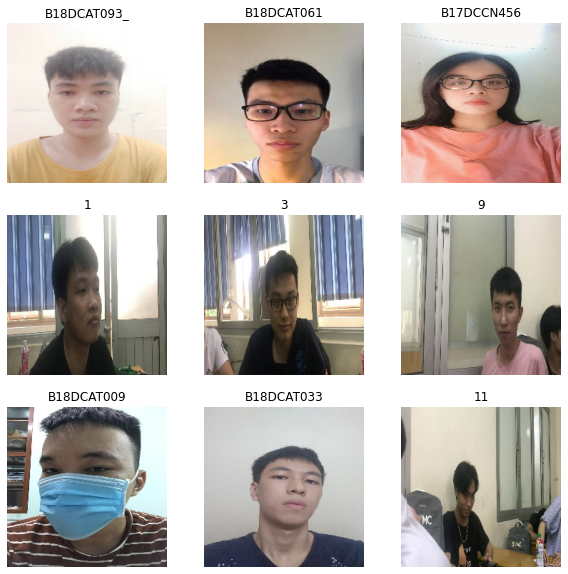

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Preprocessing Images

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.027635992 1.0


In [12]:
from tensorflow import keras
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [13]:
folders = glob(train_path + '/*')
folders

['/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT110',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT117',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT093_',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT097',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT074',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT111',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT098',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT081',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT127',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT085',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT036',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT073',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT052',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT032',
 '/content/drive/MyDrive/COMASK20_Mini_split/train/B18DCAT064',
 '/content/drive/MyDrive/COMASK20_Mini_

## Model

In [14]:
num_classes = len(class_names)
model = keras.Sequential([
    data_augmentation,

    layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(224, 224, 3), padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    #layers.MaxPool2D()
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")

])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)       

## Training the Model

In [17]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
13/13 [==============================] - 37s 2s/step - loss: 6.8559 - accuracy: 0.0299 - val_loss: 3.7379 - val_accuracy: 0.0337
Epoch 2/20
13/13 [==============================] - 1s 53ms/step - loss: 3.7071 - accuracy: 0.0796 - val_loss: 3.6104 - val_accuracy: 0.0674
Epoch 3/20
13/13 [==============================] - 1s 52ms/step - loss: 3.6000 - accuracy: 0.0920 - val_loss: 3.5024 - val_accuracy: 0.0506
Epoch 4/20
13/13 [==============================] - 1s 49ms/step - loss: 3.4922 - accuracy: 0.1095 - val_loss: 3.3437 - val_accuracy: 0.1404
Epoch 5/20
13/13 [==============================] - 1s 50ms/step - loss: 3.4269 - accuracy: 0.1194 - val_loss: 3.3355 - val_accuracy: 0.0787
Epoch 6/20
13/13 [==============================] - 1s 51ms/step - loss: 3.1425 - accuracy: 0.1990 - val_loss: 3.1499 - val_accuracy: 0.1461
Epoch 7/20
13/13 [==============================] - 1s 51ms/step - loss: 2.9539 - accuracy: 0.2836 - val_loss: 2.3855 - val_accuracy: 0.4270
Epoch 8/20
13/

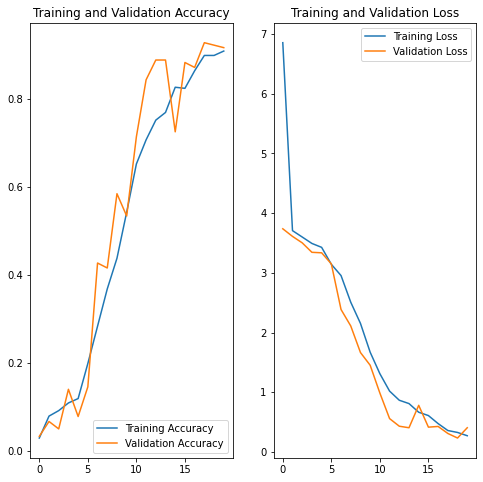

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Classifying the images

In [19]:
path = '/content/drive/MyDrive/COMASK20_Mini_split/IMG_5288_360-with-mask.jpg'

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 188ms/step
This image most likely belongs to 1 with a 99.93 percent confidence.


In [21]:
path = '/content/drive/MyDrive/COMASK20_Mini_split/IMG_5288_4740_nomask.jpg'
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
This image most likely belongs to 12 with a 92.02 percent confidence.
